# Description:
This notebook compares the accuracy of pretrained Universal Adaptation Network and the accuracy from the network's latent feature space, and shows a problem in implementing universal domain adaptation paper.

- Framework: PyTorch
- Dataset: Office-Home dataset, link: https://www.hemanthdv.org/officeHomeDataset.html
- Code reference: https://github.com/thuml/Universal-Domain-Adaptation
.Paper: https://openaccess.thecvf.com/content_CVPR_2019/papers/You_Universal_Domain_Adaptation_CVPR_2019_paper.pdf
- Metrics: Average of per-class accuracy. For feature extractor vector classification, minimum euclidean distance between feature extractor output and feature centers is used to classify images.

# Download Dataset and required configurations

In [1]:
import os
from zipfile import ZipFile
import urllib.request
import tensorflow

In [2]:
# Data
!gdown --id 1wrHGU6Vu3DknB46tueh5Hic7E9uXRVIM -O office_home.zip

Downloading...
From: https://drive.google.com/uc?id=1wrHGU6Vu3DknB46tueh5Hic7E9uXRVIM
To: /content/office_home.zip
100% 1.13G/1.13G [00:06<00:00, 185MB/s]


In [3]:
zipfile_path = '/content/office_home.zip'
with ZipFile(zipfile_path, 'r') as zipObj:
   zipObj.extractall('/content/office_home')

In [4]:
# Code:
!git clone https://github.com/thuml/Universal-Domain-Adaptation

Cloning into 'Universal-Domain-Adaptation'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 30 (delta 0), reused 1 (delta 0), pack-reused 27
Unpacking objects: 100% (30/30), done.


In [5]:
os.chdir('/content')
zipfile_path = 'office_home.zip'
with ZipFile(zipfile_path, 'r') as zipObj:
   zipObj.extractall('office_home')

In [6]:
import os
!mv /content/Universal-Domain-Adaptation /content/UDA
os.chdir('/content/UDA')

In [7]:
pip install -r requirements.txt

     |████████████████████████████████| 124 kB 7.7 MB/s 
  Created wheel for easydl: filename=easydl-2.0.7-py3-none-any.whl size=19797 sha256=c16e4f290d4873c673b85f83ca731d96c21be089e0f2627db8b3784ba98dbd7f
  Stored in directory: /root/.cache/pip/wheels/05/e0/8f/b8456f938e69b862cecfa8f03f7a063cfb77a2f253ed28ce3a
Successfully built easydl


In [8]:
# Download resnet50 to use as base_model:
os.mkdir('data/pytorchModels/')
url = 'https://download.pytorch.org/models/resnet50-0676ba61.pth'
urllib.request.urlretrieve(url, filename= "/content/UDA/data/pytorchModels/resnet50.pth")

('/content/UDA/data/pytorchModels/resnet50.pth',
 <http.client.HTTPMessage at 0x7f152d3d6810>)

In [9]:
# download Art_to_Clipart.pkl from checkpoint
!gdown --id 1j05ClEV1lIjc2WpmHRjYO9pw-M_aZQWE -O '/content/UDA/Art_to_Clipart.pkl'
filename = '/content/UDA/Art_to_Clipart.pkl'

Downloading...
From: https://drive.google.com/uc?id=1j05ClEV1lIjc2WpmHRjYO9pw-M_aZQWE
To: /content/UDA/Art_to_Clipart.pkl
100% 115M/115M [00:00<00:00, 150MB/s]


In [10]:
# Create Art.txt, Clipart.txt (images_paths, labels):
def create_txt(path,folder_name,file_name):
  print("Creating "+file_name+" file...")
  path_file_paths_labels = os.path.join(path,file_name)
  file_paths_labels = open(path_file_paths_labels, "w")
  _path = os.path.join(path,folder_name)
  _dirs = os.listdir(_path)
  sorted_dirs = sorted(_dirs)
  cnt = 0
  for i in range(len(sorted_dirs)):
    imgs_path = os.path.join(_path,sorted_dirs[i])
    imgs_names = os.listdir(imgs_path)
    imgs_names = sorted(imgs_names)
    for j in range(len(imgs_names)):
      img_path = os.path.join(imgs_path,imgs_names[j])
      file_paths_labels.write(str(img_path)+" "+str(i)+"\n")
      cnt +=1
  file_paths_labels.close()
  print("Total number of images: ", cnt)

In [11]:
create_txt('/content/office_home/OfficeHomeDataset_10072016','Art','Art.txt')
create_txt('/content/office_home/OfficeHomeDataset_10072016','Clipart','Clipart.txt')

Creating Art.txt file...
Total number of images:  2427
Creating Clipart.txt file...
Total number of images:  4365


In [12]:
# Update configurations in config.py as well as in .yaml 
# config.py
!gdown --id 1UwXjqwjUT36QJKtgsgjA3jKwHS-P4j0M -O config.py
# officehome-train-config.yaml
!gdown --id 15dytDM0pX7MAcMyZYFIjSAHcUdy6xILm
# officehome-test-config.yaml
!gdown --id 1ePn_omqRepmUhl14kYaTshsjxHCXU4o4

Downloading...
From: https://drive.google.com/uc?id=1UwXjqwjUT36QJKtgsgjA3jKwHS-P4j0M
To: /content/UDA/config.py
100% 2.32k/2.32k [00:00<00:00, 6.28MB/s]
Downloading...
From: https://drive.google.com/uc?id=15dytDM0pX7MAcMyZYFIjSAHcUdy6xILm
To: /content/UDA/officehome-train-config.yaml
100% 1.38k/1.38k [00:00<00:00, 2.02MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ePn_omqRepmUhl14kYaTshsjxHCXU4o4
To: /content/UDA/officehome-test-config.yaml
100% 1.40k/1.40k [00:00<00:00, 3.73MB/s]


# Get Feature Extractor:

In [13]:
from data import *
from net import *
from lib import *
import datetime
from tqdm import tqdm
if is_in_notebook():
    from tqdm import tqdm_notebook as tqdm
from torch import optim
from tensorboardX import SummaryWriter
import torch.backends.cudnn as cudnn
cudnn.benchmark = True
cudnn.deterministic = True

seed_everything()

if args.misc.gpus < 1:
    import os
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    gpu_ids = []
    output_device = torch.device('cpu')
else:
    gpu_ids = select_GPUs(args.misc.gpus)
    output_device = gpu_ids[0]

model_dict = {
    'resnet50': ResNet50Fc,
    'vgg16': VGG16Fc
}

class TotalNet(nn.Module):
    def __init__(self):
        super(TotalNet, self).__init__()
        self.feature_extractor = model_dict[args.model.base_model](args.model.pretrained_model)
        classifier_output_dim = len(source_classes)
        self.classifier = CLS(self.feature_extractor.output_num(), classifier_output_dim, bottle_neck_dim=256)
        self.discriminator = AdversarialNetwork(256)
        self.discriminator_separate = AdversarialNetwork(256)

    def forward(self, x):
        f = self.feature_extractor(x)
        f, _, __, y = self.classifier(f)
        d = self.discriminator(_)
        d_0 = self.discriminator_separate(_)
        return y, d, d_0

[easydl] tensorflow not available!


In [14]:
# check the accuracy:
def test_acc(dataloader):

  def outlier(each_target_share_weight):
    return each_target_share_weight < args.test.w_0
  totalNet = TotalNet()
  feature_extractor = nn.DataParallel(totalNet.feature_extractor, device_ids=gpu_ids, output_device=output_device).train(True)
  classifier = nn.DataParallel(totalNet.classifier, device_ids=gpu_ids, output_device=output_device).train(True)
  discriminator = nn.DataParallel(totalNet.discriminator, device_ids=gpu_ids, output_device=output_device).train(True)
  discriminator_separate = nn.DataParallel(totalNet.discriminator_separate, device_ids=gpu_ids, output_device=output_device).train(True)
  assert os.path.exists(args.test.resume_file)
  data = torch.load(open(args.test.resume_file, 'rb'))
  feature_extractor.load_state_dict(data['feature_extractor'])
  classifier.load_state_dict(data['classifier'])
  discriminator.load_state_dict(data['discriminator'])
  discriminator_separate.load_state_dict(data['discriminator_separate'])

  num_classes = len(source_classes)+1
  counters_ = np.zeros((num_classes,2))

  cnt = 0
  cnt_imgs = 0
  with TrainingModeManager([feature_extractor, classifier, discriminator_separate], train=False) as mgr, \
            torch.no_grad():
        for i, (im, label) in enumerate(tqdm(dataloader, desc='testing ')):
            im = im.to(output_device)
            label = label.to(output_device)

            feature = feature_extractor.forward(im)
            feature, __, before_softmax, predict_prob = classifier.forward(feature)
            domain_prob = discriminator_separate.forward(__)

            target_share_weight = get_target_share_weight(domain_prob, before_softmax, domain_temperature=1.0,
                                                          class_temperature=1.0)
            cnt_imgs +=len(label)
            for (each_predict_prob, each_label, each_target_share_weight) in zip(predict_prob, label, target_share_weight):
              if each_label in source_classes:
                  counters_[each_label,0] +=1.0
                  each_pred_id = np.argmax(each_predict_prob.cpu().numpy())
                  if not outlier(each_target_share_weight[0]) and each_pred_id == each_label:
                      cnt +=1
                      counters_[each_label,1]+=1
              else:
                  counters_[len(source_classes),0]+=1.0
                  if outlier(each_target_share_weight[0]):
                      print(counters_[len(source_classes),1])
                      cnt+=1
                      counters_[len(source_classes),1] += 1.0
  print("Total images:", cnt_imgs)
  print("Correctly Classified images: ", cnt)
  acc_test = 0.0
  nonzeros = 0
  for i in range(len(source_classes)+1):
    if(counters_[i,0]>0.0):
      print(f"Class {i} accuracy: {counters_[i,1]/counters_[i,0]}")
      acc_test += counters_[i,1]/counters_[i,0]
      nonzeros+=1
  print(f'Test accuracy is {acc_test/nonzeros*100}')

test_acc(target_test_dl) # see Table 1 in paper: Ar→ Cl
# Notice the accuracy of class 'unknown' is zero

testing :   0%|          | 0/112 [00:00<?, ?it/s]

Total images: 4021
Correctly Classified images:  522
Class 0 accuracy: 0.8166666666666667
Class 1 accuracy: 0.6785714285714286
Class 2 accuracy: 0.53125
Class 3 accuracy: 0.6020408163265306
Class 4 accuracy: 0.898989898989899
Class 5 accuracy: 0.47474747474747475
Class 6 accuracy: 0.6438356164383562
Class 7 accuracy: 0.9347826086956522
Class 8 accuracy: 0.8333333333333334
Class 9 accuracy: 0.5151515151515151
Class 15 accuracy: 0.0
Test accuracy is 62.99426689928052


In [15]:
# Get feature extractor weights from pretrained model:
from torchsummary import summary
totalNet = TotalNet()
feature_extractor = nn.DataParallel(totalNet.feature_extractor, device_ids=gpu_ids, output_device=output_device).train(True)
data = torch.load(open(args.test.resume_file, 'rb'))
feature_extractor.load_state_dict(data['feature_extractor'])

image_dim = 224
num_classes = len(source_classes) +1 # with 'unknown' class
input_shape = (3, image_dim, image_dim)
summary(feature_extractor, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
            Conv2d-2         [-1, 64, 112, 112]           9,408
       BatchNorm2d-3         [-1, 64, 112, 112]             128
       BatchNorm2d-4         [-1, 64, 112, 112]             128
              ReLU-5         [-1, 64, 112, 112]               0
              ReLU-6         [-1, 64, 112, 112]               0
         MaxPool2d-7           [-1, 64, 56, 56]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]           4,096
           Conv2d-10           [-1, 64, 56, 56]           4,096
      BatchNorm2d-11           [-1, 64, 56, 56]             128
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
             ReLU-14           [-1, 64,

In [16]:

def get_labels_centers(encoder, image_dim ,data_loader, compressed_samples_keep):
  with TrainingModeManager([encoder], train=False) as mgr, torch.no_grad():
    center_i = np.zeros((num_classes, encoder(torch.rand((image_dim))).data.shape[1]))
    cnt_center_i = np.zeros(num_classes)
    cnt_label = np.zeros(num_classes)
    X_compressed = []
    Y_labels = []
    batch_size = args.data.dataloader.batch_size
    for i, (im, label) in enumerate(tqdm(data_loader, desc='Extracting features ')):
            im = im.to(output_device)
            feature = encoder.forward(im)
            for j, each_label in zip(range(len(label)),label):
              feature_j = feature[j].cpu().numpy()
              if each_label in source_classes:
                  center_i[each_label] = np.sum([center_i[each_label], feature_j], axis = 0) 
                  cnt_center_i[each_label] +=1
                  if cnt_label[each_label] < compressed_samples_keep:
                    cnt_label[each_label] +=1
                    X_compressed.append(feature_j)
                    Y_labels.append(each_label)
              else:
                  center_i[num_classes-1] = np.sum([center_i[num_classes-1], feature_j], axis = 0) 
                  cnt_center_i[num_classes-1] +=1
                  if cnt_label[num_classes-1] < compressed_samples_keep:
                    cnt_label[num_classes-1] +=1
                    X_compressed.append(feature_j)
                    Y_labels.append(num_classes-1)
    print("Calculating centers of classes..")
    for i in range(num_classes):
      if cnt_center_i[i]>0:
        center_i[i] = center_i[i]/cnt_center_i[i]
        print(f'Center of class {i} calculated')

    print("done!")
    return center_i, np.array(X_compressed), np.array(Y_labels)    

# get centers of classes from both source and target sets:
centers, X_compressed, Y_labels = get_labels_centers(feature_extractor, image_dim ,target_train_dl, 10) # visulize 10 samples from each class
centers_, X_compressed_, Y_labels_ =get_labels_centers(feature_extractor, image_dim ,source_train_dl, 10)

Extracting features :   0%|          | 0/111 [00:00<?, ?it/s]

Calculating centers of classes..
Center of class 0 calculated
Center of class 1 calculated
Center of class 2 calculated
Center of class 3 calculated
Center of class 4 calculated
Center of class 5 calculated
Center of class 6 calculated
Center of class 7 calculated
Center of class 8 calculated
Center of class 9 calculated
Center of class 15 calculated
done!


Extracting features :   0%|          | 0/20 [00:00<?, ?it/s]

Calculating centers of classes..
Center of class 0 calculated
Center of class 1 calculated
Center of class 2 calculated
Center of class 3 calculated
Center of class 4 calculated
Center of class 5 calculated
Center of class 6 calculated
Center of class 7 calculated
Center of class 8 calculated
Center of class 9 calculated
Center of class 10 calculated
Center of class 11 calculated
Center of class 12 calculated
Center of class 13 calculated
Center of class 14 calculated
done!


## Visualization

In [17]:
# using TSNE for visualization
from sklearn.manifold import TSNE

X_valid_concat = np.concatenate([X_compressed,X_compressed_, centers, centers_] , axis = 0)
y_valid_concat = np.concatenate([np.array(Y_labels),np.array(Y_labels_),np.array(range(num_classes)), np.array(range(num_classes))])

tsne = TSNE()
X_all_valid_2D = tsne.fit_transform(X_valid_concat)

cmap = plt.cm.Spectral
cmap = plt.cm.nipy_spectral
norm = plt.Normalize(vmin=0, vmax=num_classes-1)


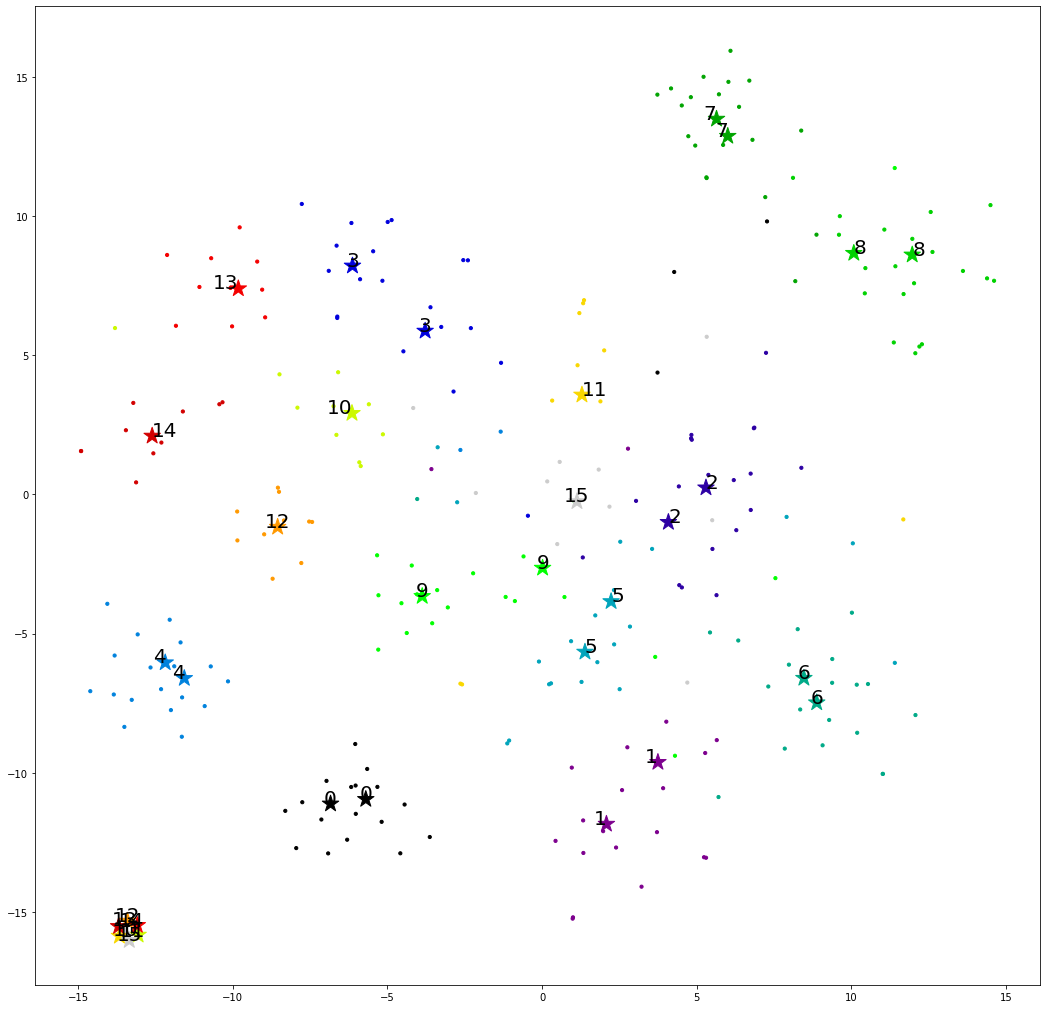

In [18]:
fig, ax = plt.subplots(figsize=(18,18))
ax.scatter(X_all_valid_2D[:-2*num_classes, 0], X_all_valid_2D[:-2*num_classes, 1], norm = norm, c = y_valid_concat[:-2*num_classes], s=10, cmap = cmap)
ax.scatter(X_all_valid_2D[-2*num_classes:, 0], X_all_valid_2D[-2*num_classes:, 1], norm = norm, c= y_valid_concat[-2*num_classes:], s=300, cmap = cmap, marker = '*')

text_pos = ['center','right','left']
for i in range(num_classes):# (text, xy)
    ax.annotate(y_valid_concat[-2*num_classes:-num_classes][i], (X_all_valid_2D[-2*num_classes:-num_classes, 0][i], X_all_valid_2D[-2*num_classes:-num_classes, 1][i]), fontsize=20, ha=text_pos[i%len(text_pos)])
    ax.annotate(y_valid_concat[-num_classes:][i], (X_all_valid_2D[-num_classes:, 0][i], X_all_valid_2D[-num_classes:, 1][i]), fontsize=20, ha=text_pos[i%len(text_pos)])
# Notice that the labels 10,11,12,13,14 from source_train dataset not exist, and gathered within the same area

In [19]:
# merging the centers:
a = args.data.dataset.n_share
b = args.data.dataset.n_share+args.data.dataset.n_source_private
merged_centers = np.zeros(centers.shape)
for i in range(a):
  merged_centers[i] = (centers[i]+centers_[i])/2.  # approximation 
for i in range(a,b):
  merged_centers[i] = centers_[i] # get the centers of private classes from source centers
merged_centers[num_classes-1] = centers[num_classes-1]

In [20]:
# plot in 2-D with merged_centers:
X_valid_concat_merged = np.concatenate([X_compressed, X_compressed_, merged_centers] , axis = 0)
y_valid_concat_merged = np.concatenate([np.array(Y_labels), np.array(Y_labels_), np.array(range(num_classes))])
tsne_ = TSNE()
X_all_valid_2D_merged = tsne_.fit_transform(X_valid_concat_merged)

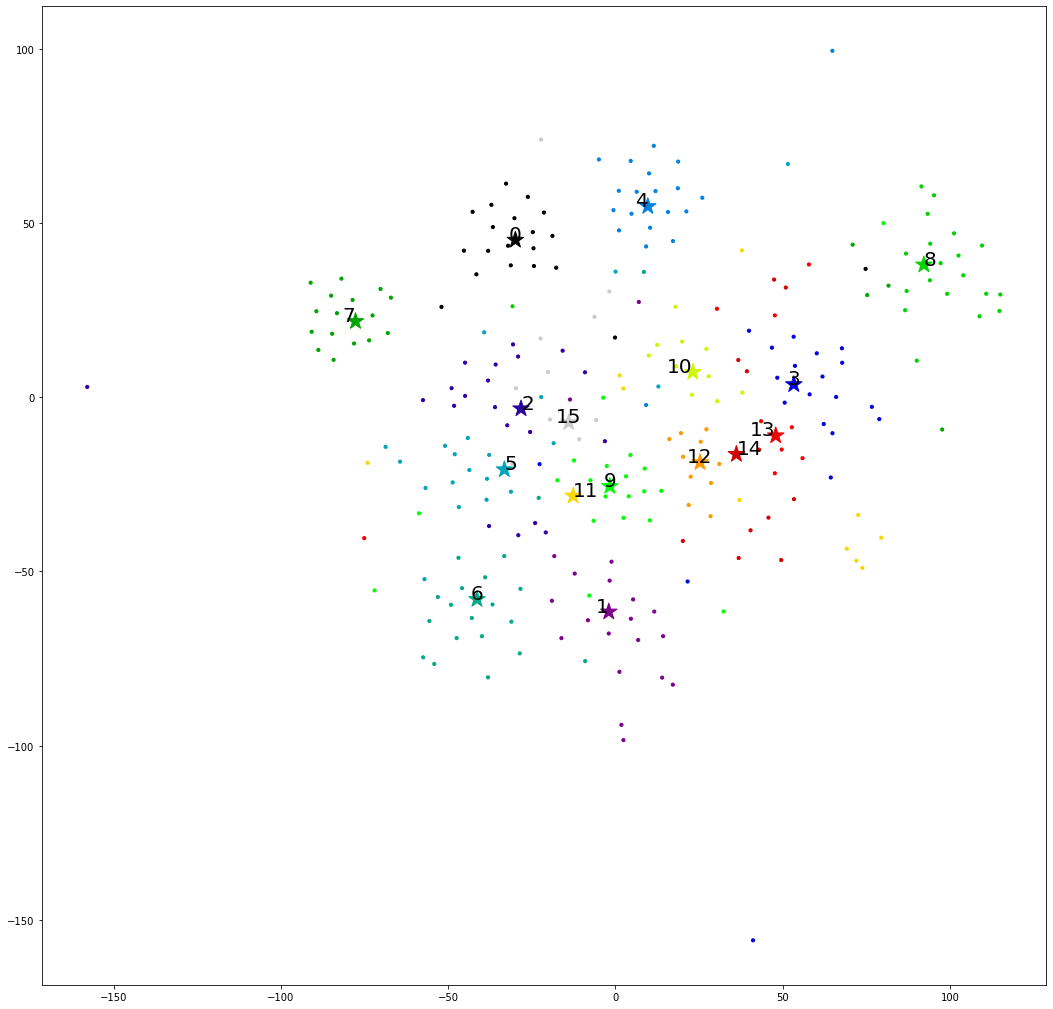

In [21]:
fig, ax = plt.subplots(figsize=(18,18))
ax.scatter(X_all_valid_2D_merged[:-num_classes, 0], X_all_valid_2D_merged[:-num_classes, 1], norm = norm, c = y_valid_concat_merged[:-num_classes], s=10, cmap = cmap)
ax.scatter(X_all_valid_2D_merged[-num_classes:, 0], X_all_valid_2D_merged[-num_classes:, 1], norm = norm, c= y_valid_concat_merged[-num_classes:], s=300, cmap = cmap, marker = '*')

text_pos = ['center','right','left']
for i in range(num_classes):# (text, xy)
    ax.annotate(y_valid_concat_merged[-num_classes:][i], (X_all_valid_2D_merged[-num_classes:, 0][i], X_all_valid_2D_merged[-num_classes:, 1][i]), fontsize=20, ha=text_pos[i%len(text_pos)])
# Notice that samples from each source class are gathered around their center.

# Accuracy:


In [22]:
def min_dist(vec, centers):
  # define a distance function
  dist = np.inf
  pred_class = -1
  for i in range(len(centers)):
    dist_i = np.linalg.norm(vec-centers[i])
    if dist_i<dist:
      dist = dist_i
      pred_class = i
  return pred_class

def calc_accuracy_latent_space(encoder_model, data_loader, merged_centers):
  counters_ = np.zeros((num_classes,2))
  cnt = 0
  encoder_acc = 0.
  with TrainingModeManager([encoder_model], train=False) as mgr, torch.no_grad():
        for i, (im, label) in enumerate(tqdm(data_loader, desc='testing ')):
              im = im.to(output_device)
              feature = encoder_model.forward(im)
              for j, each_label in zip(range(len(label)),label):
                cnt+=1
                if each_label>args.data.dataset.n_share+args.data.dataset.n_source_private:
                  each_label = args.data.dataset.n_share+args.data.dataset.n_source_private
                counters_[each_label,0] +=1.0
                feature_j = feature[j].cpu().numpy()
                pred_label_enc = min_dist(np.squeeze(feature_j), merged_centers)
                if (pred_label_enc == each_label):
                  counters_[each_label,1]+=1
  acc_test = 0.0
  cnt = 0
  for i in range(len(source_classes)+1):
    if(counters_[i,0]>0.0):
      print(f"Accuracy for class {i} is {counters_[i,1]/counters_[i,0]}")
      acc_test += counters_[i,1]/counters_[i,0]
      cnt+=1
  print(f'Average accuracy is {acc_test/cnt*100}')        
  return  acc_test/cnt*100


In [23]:
enc_acc = calc_accuracy_latent_space(feature_extractor, target_test_dl, merged_centers)
# Notice that we got higher accuracy using latent space than accuracy using proposed method

testing :   0%|          | 0/112 [00:00<?, ?it/s]

Accuracy for class 0 is 0.8166666666666667
Accuracy for class 1 is 0.75
Accuracy for class 2 is 0.65625
Accuracy for class 3 is 0.6632653061224489
Accuracy for class 4 is 0.898989898989899
Accuracy for class 5 is 0.5252525252525253
Accuracy for class 6 is 0.726027397260274
Accuracy for class 7 is 0.9130434782608695
Accuracy for class 8 is 0.7435897435897436
Accuracy for class 9 is 0.5757575757575758
Accuracy for class 15 is 0.5253924284395198
Average accuracy is 70.85668200308656
